# Decision Tree - v1

In [80]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from sklearn import preprocessing
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeClassifier
import geopy
from geopy.distance import geodesic
import os
import pickle


In [81]:
import time
start_time = time.time()
print(f"{model_specs}_{dataset_type} Notebook started at: {time.ctime(start_time)}")


Notebook started at: Sun Oct 27 07:46:54 2024


In [ ]:
model_specs = 'DecisionTrees'


'''
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from sklearn.svm import SVC
import sklearn.metrics as metrics
from sklearn.metrics import jaccard_score
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
'''


In [82]:
# Define which dataset to use
use_test_data = False  # Set to True when using fraudtest.csv

# Determine dataset type based on the variable
dataset_type = 'Test' if use_test_data else 'Train'



In [83]:
# Directory to save the figures 

input_src_dir = '/Users/sadhvichandragiri/desktop/coding/ZHAW_Project/ML_BigData_Repo_1/data/raw'
output_dir_figures_train = '/Users/sadhvichandragiri/desktop/coding/ZHAW_Project/ML_BigData_Repo_1/reports/figures/train_figures'
output_dir_figures_test = '/Users/sadhvichandragiri/desktop/coding/ZHAW_Project/ML_BigData_Repo_1/reports/figures/test_figures'
reports_output_dir = '/Users/sadhvichandragiri/desktop/coding/ZHAW_Project/ML_BigData_Repo_1/reports'

In [ ]:
# Generate the preprocess file name dynamically
# Get the current timestamp
timestamp = time.strftime("%Y%m%d_%H%M%S")  # Format: YYYYMMDD_HHMMSS

logfile_title = 'LogFile'
logfile_name = f"{model_specs}_{dataset_type}_{logfile_title.replace(',', '').lower().split('.')[0]}_{timestamp}.txt"

logfile_path = os.path.join(reports_output_dir, logfile_name)

# Function to log times to a file
def log_time(step_name, start_time):
    end_time = time.time()
    elapsed_time = end_time - start_time
    log_message = (f"{step_name} completed at {time.ctime(end_time)}. "
                   f"Elapsed time: {elapsed_time // 60:.0f} minutes and {elapsed_time % 60:.2f} seconds\n")
    
    # Append log to file
    with open(logfile_path, 'a') as f:
        f.write(log_message)
    
    # Print the message to the console as well
    print(log_message)


In [ ]:

log_time(f"{model_specs}_{dataset_type} Notebook  started at... ", start_time_notebook)
start_time = time.time()


In [85]:
# Load the appropriate dataset

if use_test_data:
    df = pd.read_csv(f"{input_src_dir}/fraudTest.csv")  # Concatenate the directory with the filename
else:
    df = pd.read_csv(f"{input_src_dir}/fraudTrain.csv")


In [86]:
print(df.columns)
print(df.shape)


Index(['Unnamed: 0', 'trans_date_trans_time', 'cc_num', 'merchant', 'category',
       'amt', 'first', 'last', 'gender', 'street', 'city', 'state', 'zip',
       'lat', 'long', 'city_pop', 'job', 'dob', 'trans_num', 'unix_time',
       'merch_lat', 'merch_long', 'is_fraud'],
      dtype='object')
(555719, 23)


In [87]:
df.columns = df.columns.str.strip()


In [88]:
df = df.rename(columns={'amt': 'TransactionAmount', 'cc_num': 'CreditCardNumber', 'dob': 'DateOfBirth', 'trans_date_trans_time': 'TransactionTime'})


In [89]:
print(df.columns)


Index(['Unnamed: 0', 'TransactionTime', 'CreditCardNumber', 'merchant',
       'category', 'TransactionAmount', 'first', 'last', 'gender', 'street',
       'city', 'state', 'zip', 'lat', 'long', 'city_pop', 'job', 'DateOfBirth',
       'trans_num', 'unix_time', 'merch_lat', 'merch_long', 'is_fraud'],
      dtype='object')


In [90]:
# Generate a unique TransactionID for each row
df['TransactionID'] = range(1, len(df) + 1)


In [91]:
# Drop the 'Unnamed: 0' column
#df = df.drop(columns=['Unnamed: 0'])

# Verify it's gone
print(df.head())

   Unnamed: 0      TransactionTime  CreditCardNumber  \
0           0  2020-06-21 12:14:25  2291163933867244   
1           1  2020-06-21 12:14:33  3573030041201292   
2           2  2020-06-21 12:14:53  3598215285024754   
3           3  2020-06-21 12:15:15  3591919803438423   
4           4  2020-06-21 12:15:17  3526826139003047   

                               merchant        category  TransactionAmount  \
0                 fraud_Kirlin and Sons   personal_care               2.86   
1                  fraud_Sporer-Keebler   personal_care              29.84   
2  fraud_Swaniawski, Nitzsche and Welch  health_fitness              41.28   
3                     fraud_Haley Group        misc_pos              60.05   
4                 fraud_Johnston-Casper          travel               3.19   

    first      last gender                       street  ...      long  \
0    Jeff   Elliott      M            351 Darlene Green  ...  -80.9355   
1  Joanne  Williams      F             3638 Ma

In [92]:
# Check for missing values
missing_values = df.isnull().sum()
print("Missing values per column:\n", missing_values)

# no missing values

Missing values per column:
 Unnamed: 0           0
TransactionTime      0
CreditCardNumber     0
merchant             0
category             0
TransactionAmount    0
first                0
last                 0
gender               0
street               0
city                 0
state                0
zip                  0
lat                  0
long                 0
city_pop             0
job                  0
DateOfBirth          0
trans_num            0
unix_time            0
merch_lat            0
merch_long           0
is_fraud             0
TransactionID        0
dtype: int64


In [93]:
# Count of fraud and non-fraud transactions
fraud_counts = df['is_fraud'].value_counts()
print(fraud_counts)

# Optionally, you can get it in percentage terms
fraud_percentage = df['is_fraud'].value_counts(normalize=True) * 100
print(fraud_percentage)


is_fraud
0    553574
1      2145
Name: count, dtype: int64
is_fraud
0    99.614014
1     0.385986
Name: proportion, dtype: float64


In [94]:
#how many unique credit cards in the data set ??
df['CreditCardNumber'].nunique()

924

In [95]:
print(df.columns)

Index(['Unnamed: 0', 'TransactionTime', 'CreditCardNumber', 'merchant',
       'category', 'TransactionAmount', 'first', 'last', 'gender', 'street',
       'city', 'state', 'zip', 'lat', 'long', 'city_pop', 'job', 'DateOfBirth',
       'trans_num', 'unix_time', 'merch_lat', 'merch_long', 'is_fraud',
       'TransactionID'],
      dtype='object')


In [96]:
# Convert TransactionTime to datetime
df['TransactionTime'] = pd.to_datetime(df['TransactionTime'])

# Optional: Convert DateOfBirth to datetime, if needed
df['DateOfBirth'] = pd.to_datetime(df['DateOfBirth'], errors='coerce')

In [97]:
# Set 'TransactionTime' as the index permanently
df.set_index('TransactionTime', inplace=True)

# Verify the index
print(df.index)


DatetimeIndex(['2020-06-21 12:14:25', '2020-06-21 12:14:33',
               '2020-06-21 12:14:53', '2020-06-21 12:15:15',
               '2020-06-21 12:15:17', '2020-06-21 12:15:37',
               '2020-06-21 12:15:44', '2020-06-21 12:15:50',
               '2020-06-21 12:16:10', '2020-06-21 12:16:11',
               ...
               '2020-12-31 23:57:18', '2020-12-31 23:57:50',
               '2020-12-31 23:57:56', '2020-12-31 23:58:04',
               '2020-12-31 23:58:34', '2020-12-31 23:59:07',
               '2020-12-31 23:59:09', '2020-12-31 23:59:15',
               '2020-12-31 23:59:24', '2020-12-31 23:59:34'],
              dtype='datetime64[ns]', name='TransactionTime', length=555719, freq=None)


In [98]:
# Get the minimum and maximum transaction times from the index
min_time = df.index.min()
max_time = df.index.max()

print(f"Minimum Transaction Time: {min_time}")
print(f"Maximum Transaction Time: {max_time}")


Minimum Transaction Time: 2020-06-21 12:14:25
Maximum Transaction Time: 2020-12-31 23:59:34


In [99]:
df.head()

,Unnamed: 0,CreditCardNumber,merchant,category,TransactionAmount,first,last,gender,street,city,...,long,city_pop,job,DateOfBirth,trans_num,unix_time,merch_lat,merch_long,is_fraud,TransactionID
TransactionTime,,,,,,,,,,,,,,,,,,,,,
2020-06-21 12:14:25,0,2291163933867244,fraud_Kirlin and Sons,personal_care,2.86,Jeff,Elliott,M,351 Darlene Green,Columbia,...,-80.9355,333497,Mechanical engineer,1968-03-19,2da90c7d74bd46a0caf3777415b3ebd3,1371816865,33.986391,-81.200714,0,1
2020-06-21 12:14:33,1,3573030041201292,fraud_Sporer-Keebler,personal_care,29.84,Joanne,Williams,F,3638 Marsh Union,Altonah,...,-110.4360,302,"Sales professional, IT",1990-01-17,324cc204407e99f51b0d6ca0055005e7,1371816873,39.450498,-109.960431,0,2
2020-06-21 12:14:53,2,3598215285024754,"fraud_Swaniawski, Nitzsche and Welch",health_fitness,41.28,Ashley,Lopez,F,9333 Valentine Point,Bellmore,...,-73.5365,34496,"Librarian, public",1970-10-21,c81755dbbbea9d5c77f094348a7579be,1371816893,40.495810,-74.196111,0,3
2020-06-21 12:15:15,3,3591919803438423,fraud_Haley Group,misc_pos,60.05,Brian,Williams,M,32941 Krystal Mill Apt. 552,Titusville,...,-80.8191,54767,Set designer,1987-07-25,2159175b9efe66dc301f149d3d5abf8c,1371816915,28.812398,-80.883061,0,4
2020-06-21 12:15:17,4,3526826139003047,fraud_Johnston-Casper,travel,3.19,Nathan,Massey,M,5783 Evan Roads Apt. 465,Falmouth,...,-85.0170,1126,Furniture designer,1955-07-06,57ff021bd3f328f8738bb535c302a31b,1371816917,44.959148,-85.884734,0,5


In [ ]:
log_time("Initial Steps Completed File Loading, Describe, Date Conversions etc..  ", start_time)
log_time("--------------------------------------------------- ------------------  ", start_time)
start_time = time.time()

# Feature Engineering

In [ ]:
log_time("START - Feature Engineering .....  ", start_time)
start_time = time.time()

In [100]:

# Clip outliers if necessary
df['TransactionAmount'] = df['TransactionAmount'].clip(upper=df['TransactionAmount'].quantile(0.99))



In [101]:

# Replace inf values with NaN (in case they exist in the 'TransactionAmount' column)
df['TransactionAmount'].replace([np.inf, -np.inf], np.nan, inplace=True)


/var/folders/xp/synrlbr15rx4pkqjmwqk80k80000gn/T/ipykernel_1131/1075701793.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['TransactionAmount'].replace([np.inf, -np.inf], np.nan, inplace=True)


# next type of VIZ via transaction id vs transaction count


In [102]:
# Extract hour from TransactionTime
df['Hour'] = df.index.hour  # Since TransactionTime is already set as the index


In [103]:
# Calculate fraud rate by hour
fraud_rate_by_hour = df.groupby('Hour')['is_fraud'].mean()

# Sort by fraud rate in descending order
fraud_rate_by_hour = fraud_rate_by_hour.sort_values(ascending=False)

# Define a threshold for high-risk hours (adjust as needed)
threshold = fraud_rate_by_hour.mean()  # Mean fraud rate across all hours

# Dynamically identify high-risk hours based on the threshold
high_risk_hours = fraud_rate_by_hour[fraud_rate_by_hour > threshold].index.tolist()

# Print high-risk hours for reference
print("High-Risk Hours:", high_risk_hours)

# Create the HighRiskHour flag based on dynamically identified high-risk hours
df['HighRiskHour'] = df['Hour'].apply(lambda x: 1 if x in high_risk_hours else 0)

# Print a sample of the DataFrame to verify the new column
print(df[['Hour', 'HighRiskHour']])


High-Risk Hours: [22, 23, 3, 0, 2, 1]
                     Hour  HighRiskHour
TransactionTime                        
2020-06-21 12:14:25    12             0
2020-06-21 12:14:33    12             0
2020-06-21 12:14:53    12             0
2020-06-21 12:15:15    12             0
2020-06-21 12:15:17    12             0
...                   ...           ...
2020-12-31 23:59:07    23             1
2020-12-31 23:59:09    23             1
2020-12-31 23:59:15    23             1
2020-12-31 23:59:24    23             1
2020-12-31 23:59:34    23             1

[555719 rows x 2 columns]


# Further analysis on data

1. Time-Based Analysis:
Already explored daily and hourly trends in transaction volumes, but now dive deeper into fraud patterns based on time.



In [104]:
#Weekday vs. Weekend: Is fraud more common on weekdays or weekends?
df['DayOfWeek'] = df.index.dayofweek  # 0 = Monday, 6 = Sunday
fraud_by_day = df[df['is_fraud'] == 1]['DayOfWeek'].value_counts().sort_index()
non_fraud_by_day = df[df['is_fraud'] == 0]['DayOfWeek'].value_counts().sort_index()



In [105]:

# Define the correct day order
day_order = ['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday']


df['DayName'] = df.index.day_name()
# Convert the 'DayName' column to a categorical type with the correct order
df['DayName'] = pd.Categorical(df['DayName'], categories=day_order, ordered=True)

fraud_by_day = df[df['is_fraud'] == 1]['DayName'].value_counts().sort_index()
non_fraud_by_day = df[df['is_fraud'] == 0]['DayName'].value_counts().sort_index()



In [106]:
df['IsWeekend'] = df['DayOfWeek'].apply(lambda x: 1 if x >= 5 else 0)
weekend_fraud = df[df['is_fraud'] == 1]['IsWeekend'].mean()
weekend_non_fraud = df[df['is_fraud'] == 0]['IsWeekend'].mean()

print(f"Percentage of fraud on weekends: {weekend_fraud * 100:.2f}%")
print(f"Percentage of non-fraud on weekends: {weekend_non_fraud * 100:.2f}%")


Percentage of fraud on weekends: 29.84%
Percentage of non-fraud on weekends: 27.95%


In [ ]:
log_time("Part1 - TrxAmount, Hour, DayOfWeeek etc..", start_time)
start_time = time.time()

In [107]:
#location based analysis

In [108]:


# Calculate distance between cardholder and merchant
df['distance'] = df.apply(lambda row: geodesic((row['lat'], row['long']), (row['merch_lat'], row['merch_long'])).km, axis=1)



In [ ]:
log_time("Part2 - Distance Calculation ", start_time)
start_time = time.time()

In [109]:
# Check unique values in the 'is_fraud' column
df['is_fraud'].unique()


array([0, 1])

In [110]:
# Fraud vs Non-Fraud by Merchant Category
fraud_by_category = df[df['is_fraud'] == 1]['category'].value_counts().head(10)
non_fraud_by_category = df[df['is_fraud'] == 0]['category'].value_counts().head(10)





In [111]:
# Top 5 categories with the highest fraud counts
top_fraud_merchant_categories = df[df['is_fraud'] == 1]['category'].value_counts().head(5).index.tolist()

# Print top fraudulent categories
print("Top Fraudulent Merchant Categories:", top_fraud_merchant_categories)

# Create HighRiskMerchantCategory flag
df['HighRiskMerchantCategory'] = df['category'].apply(lambda x: 1 if x in top_fraud_merchant_categories else 0)



Top Fraudulent Merchant Categories: ['shopping_net', 'grocery_pos', 'misc_net', 'shopping_pos', 'gas_transport']


In [112]:
# Print the count of 1s and 0s in HighRiskMerchantCategory
print(df['HighRiskMerchantCategory'].value_counts())


HighRiskMerchantCategory
0    327859
1    227860
Name: count, dtype: int64


In [ ]:
log_time("Part3 - Merchant Categories & Age group", start_time)
start_time = time.time()

# Potential Additional Features:
Transaction Frequency:
    Feature: How often a credit card has been used within a specific time frame (e.g., last hour or day).
    Why: Fraudsters often make rapid successive transactions within short periods. You could create a rolling window to calculate transaction frequency.
    How: You could calculate the number of transactions within the past X hours/days using a rolling window on the TransactionTime feature.

#age group

In [113]:
import pandas as pd

# Ensure 'DateOfBirth' is in datetime format
df['DateOfBirth'] = pd.to_datetime(df['DateOfBirth'], errors='coerce')  # Handle errors during conversion

# Step 1: Calculate Age
# Calculate age in years
df['Age'] = (pd.Timestamp.now() - df['DateOfBirth']).dt.days // 365  # Age in years

# Step 2: Create Age Groups
# Define age bins and labels
bins = [0, 18, 25, 35, 45, 55, 65, 100]  # Define your age bins, ensuring to cover all possible ages
labels = ['0-18', '19-25', '26-35', '36-45', '46-55', '56-65', '66+']  # Corresponding labels

# Create age group feature, include NaN values handling
df['AgeGroup'] = pd.cut(df['Age'], bins=bins, labels=labels, right=False, include_lowest=True)

# Verify the new features without truncating DataFrame
#print(df[['DateOfBirth', 'Age', 'AgeGroup']].head(10))  # Display the first 10 entries


In [114]:
def count_transactions_within_last_hour(group):
    # Create an empty list to hold the frequencies
    frequencies = []
    
    # Loop over each transaction time in the group
    for time in group.index:
        # Count the number of transactions within the last hour
        count = group[(group.index >= (time - pd.Timedelta(hours=1))) & (group.index <= time)].shape[0]
        frequencies.append(count)
    
    return frequencies

# Apply the function to each group
df['TransactionFrequency'] = df.groupby('CreditCardNumber').apply(count_transactions_within_last_hour).reset_index(drop=True)
print(df[['TransactionFrequency']].head(10))  # Display the first 10 entries


                    TransactionFrequency
TransactionTime                         
2020-06-21 12:14:25                  NaN
2020-06-21 12:14:33                  NaN
2020-06-21 12:14:53                  NaN
2020-06-21 12:15:15                  NaN
2020-06-21 12:15:17                  NaN
2020-06-21 12:15:37                  NaN
2020-06-21 12:15:44                  NaN
2020-06-21 12:15:50                  NaN
2020-06-21 12:16:10                  NaN
2020-06-21 12:16:11                  NaN


/var/folders/xp/synrlbr15rx4pkqjmwqk80k80000gn/T/ipykernel_1131/2620616198.py:14: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df['TransactionFrequency'] = df.groupby('CreditCardNumber').apply(count_transactions_within_last_hour).reset_index(drop=True)


In [ ]:
# Log the time taken for transaction frequency calculation with multiprocessing
log_time("Part4 - TransactionFrequency Multiprocessing", start_time)
start_time = time.time()

In [115]:
# Resample the data to count transactions every hour
transaction_counts_hourly = df.resample('H').size()
transaction_counts_daily = df.resample('D').size()

# Combine with CreditCardNumber if necessary
transaction_counts = df.groupby('CreditCardNumber').resample('H').size().reset_index(name='TransactionCount')
print(transaction_counts.head(10))

/var/folders/xp/synrlbr15rx4pkqjmwqk80k80000gn/T/ipykernel_1131/1490275857.py:2: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  transaction_counts_hourly = df.resample('H').size()
/var/folders/xp/synrlbr15rx4pkqjmwqk80k80000gn/T/ipykernel_1131/1490275857.py:6: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  transaction_counts = df.groupby('CreditCardNumber').resample('H').size().reset_index(name='TransactionCount')


   CreditCardNumber     TransactionTime  TransactionCount
0       60416207185 2020-06-21 13:00:00                 1
1       60416207185 2020-06-21 14:00:00                 0
2       60416207185 2020-06-21 15:00:00                 0
3       60416207185 2020-06-21 16:00:00                 1
4       60416207185 2020-06-21 17:00:00                 0
5       60416207185 2020-06-21 18:00:00                 0
6       60416207185 2020-06-21 19:00:00                 0
7       60416207185 2020-06-21 20:00:00                 0
8       60416207185 2020-06-21 21:00:00                 0
9       60416207185 2020-06-21 22:00:00                 0


In [116]:
total_transactions = df.groupby('CreditCardNumber').size().reset_index(name='TotalTransactionCount')
print(total_transactions.head(10))


   CreditCardNumber  TotalTransactionCount
0       60416207185                    678
1       60422928733                    669
2       60423098130                    228
3       60427851591                    215
4       60487002085                    239
5       60490596305                    455
6       60495593109                    224
7      501802953619                    635
8      501828204849                    218
9      501831082224                    439


In [117]:
# Calculate the time difference between consecutive transactions
time_diff = df.index.to_series().diff().dt.total_seconds()
# Flag rapid transactions (within 5 minutes)
df['RapidTransactionFlag'] = time_diff < 60  # For a 1-minute threshold

# Create a temporary DataFrame for rapid transactions
rapid_transactions = df[df['RapidTransactionFlag']]

# Group by date and count the number of rapid transactions
rapid_transaction_counts = rapid_transactions.groupby(rapid_transactions.index.date).size()
print(rapid_transaction_counts)

# Get a summary of the rapid transactions
rapid_transactions_summary = rapid_transactions.describe()
print(rapid_transactions_summary)


2020-06-21    1908
2020-06-22    3834
2020-06-23    3602
2020-06-24    1352
2020-06-25    1578
              ... 
2020-12-27    5183
2020-12-28    6212
2020-12-29    6123
2020-12-30    2630
2020-12-31    3044
Length: 194, dtype: int64
          Unnamed: 0  CreditCardNumber  TransactionAmount            zip  \
count  478827.000000      4.788270e+05      478827.000000  478827.000000   
mean   282352.474282      4.156977e+17          63.671204   48855.657540   
min         1.000000      6.041621e+10           1.000000    1257.000000   
25%    139140.500000      1.800429e+14           9.510000   26292.000000   
50%    283432.000000      3.521417e+15          46.370000   48174.000000   
75%    429493.500000      4.635331e+15          82.260000   72042.000000   
max    555718.000000      4.992346e+18         519.854600   99921.000000   
std    163611.709333      1.306822e+18          78.874224   26858.296762   

                 lat           long      city_pop  \
count  478827.000000  47882

In [118]:
print(df.columns)


Index(['Unnamed: 0', 'CreditCardNumber', 'merchant', 'category',
       'TransactionAmount', 'first', 'last', 'gender', 'street', 'city',
       'state', 'zip', 'lat', 'long', 'city_pop', 'job', 'DateOfBirth',
       'trans_num', 'unix_time', 'merch_lat', 'merch_long', 'is_fraud',
       'TransactionID', 'Hour', 'HighRiskHour', 'DayOfWeek', 'DayName',
       'IsWeekend', 'distance', 'HighRiskMerchantCategory', 'Age', 'AgeGroup',
       'TransactionFrequency', 'RapidTransactionFlag'],
      dtype='object')


In [ ]:
log_time("Part5 - RapidTransactionFlag", start_time)
start_time = time.time()


Transaction Amount Features:
Log Transaction Amount: Normalize the TransactionAmount by taking its logarithm to reduce skewness.
Transaction Amount Flags: Create binary flags for high-value transactions (e.g., if TransactionAmount exceeds a certain threshold).

In [119]:

# Sample DataFrame creation
# Assume 'df' is your DataFrame and has a 'TransactionAmount' column
# df = pd.read_csv('your_data.csv')  # Load your actual data

# Step 1: Log Transaction Amount
# Calculate the log of TransactionAmount
df['LogTransactionAmount'] = np.log1p(df['TransactionAmount'])  # Use log1p for stability with 0 values

# Step 2: Create Transaction Amount Flags
# Define a threshold for high-value transactions
threshold = 100  # Adjust the threshold based on your data context

# Create a flag for high-value transactions
df['HighValueTransactionFlag'] = df['TransactionAmount'] > threshold

# Verify the new features
print(df[['TransactionAmount', 'LogTransactionAmount', 'HighValueTransactionFlag']].head(10))  # Display the first 10 entries


                     TransactionAmount  LogTransactionAmount  \
TransactionTime                                                
2020-06-21 12:14:25               2.86              1.350667   
2020-06-21 12:14:33              29.84              3.428813   
2020-06-21 12:14:53              41.28              3.744314   
2020-06-21 12:15:15              60.05              4.111693   
2020-06-21 12:15:17               3.19              1.432701   
2020-06-21 12:15:37              19.55              3.022861   
2020-06-21 12:15:44             133.93              4.904756   
2020-06-21 12:15:50              10.37              2.430978   
2020-06-21 12:16:10               4.37              1.680828   
2020-06-21 12:16:11              66.54              4.212720   

                     HighValueTransactionFlag  
TransactionTime                                
2020-06-21 12:14:25                     False  
2020-06-21 12:14:33                     False  
2020-06-21 12:14:53                    

Behavioral Features:
Count of Transactions in Last X Days: Count how many transactions have occurred in the last 7, 14, or 30 days.
Average Transaction Amount in Last X Days: Calculate the average transaction amount over the same periods.

In [120]:
import pandas as pd

# Assuming 'TransactionTime' is already set as the index and in datetime format

# Step 1: Count of Transactions in Last X Days
for days in [7, 14, 30]:
    # Sort data by CreditCardNumber and TransactionTime to ensure rolling works properly
    df = df.sort_values(by=['CreditCardNumber', 'TransactionTime'])
    
    # Apply rolling and count the number of transactions for each card
    df[f'TransactionCountLast{days}Days'] = (
        df.groupby('CreditCardNumber')['CreditCardNumber']
        .rolling(f'{days}D')
        .count()
        .reset_index(level=0, drop=True)
    )

# Step 2: Average Transaction Amount in Last X Days
for days in [7, 14, 30]:
    # Sort data by CreditCardNumber and TransactionTime to ensure rolling works properly
    df = df.sort_values(by=['CreditCardNumber', 'TransactionTime'])
    
    # Calculate the average transaction amount for each credit card in the last X days
    df[f'AverageTransactionAmountLast{days}Days'] = (
        df.groupby('CreditCardNumber')['TransactionAmount']
        .rolling(f'{days}D')
        .mean()
        .reset_index(level=0, drop=True)
    )

# Verify the new features
print(df[['TransactionCountLast7Days', 'TransactionCountLast14Days', 'TransactionCountLast30Days',
           'AverageTransactionAmountLast7Days', 'AverageTransactionAmountLast14Days', 'AverageTransactionAmountLast30Days']].head(10))


                     TransactionCountLast7Days  TransactionCountLast14Days  \
TransactionTime                                                              
2020-06-21 13:05:42                        1.0                         1.0   
2020-06-21 16:25:36                        2.0                         2.0   
2020-06-22 07:58:33                        3.0                         3.0   
2020-06-22 15:32:31                        4.0                         4.0   
2020-06-23 12:28:54                        5.0                         5.0   
2020-06-23 14:24:48                        6.0                         6.0   
2020-06-23 16:39:40                        7.0                         7.0   
2020-06-23 19:07:05                        8.0                         8.0   
2020-06-23 22:45:57                        9.0                         9.0   
2020-06-24 04:22:17                       10.0                        10.0   

                     TransactionCountLast30Days  \
TransactionT

In [121]:
print(df.columns)  # Display all columns in the DataFrame


Index(['Unnamed: 0', 'CreditCardNumber', 'merchant', 'category',
       'TransactionAmount', 'first', 'last', 'gender', 'street', 'city',
       'state', 'zip', 'lat', 'long', 'city_pop', 'job', 'DateOfBirth',
       'trans_num', 'unix_time', 'merch_lat', 'merch_long', 'is_fraud',
       'TransactionID', 'Hour', 'HighRiskHour', 'DayOfWeek', 'DayName',
       'IsWeekend', 'distance', 'HighRiskMerchantCategory', 'Age', 'AgeGroup',
       'TransactionFrequency', 'RapidTransactionFlag', 'LogTransactionAmount',
       'HighValueTransactionFlag', 'TransactionCountLast7Days',
       'TransactionCountLast14Days', 'TransactionCountLast30Days',
       'AverageTransactionAmountLast7Days',
       'AverageTransactionAmountLast14Days',
       'AverageTransactionAmountLast30Days'],
      dtype='object')


In [ ]:
log_time("Part6 - TransactionCountLast_X_Days & AverageTrxAmountLast_X_Days", start_time)
start_time = time.time()

# Graph Construction with NetworkX:

Highlight Fraudulent Nodes: Overlay of fraudulent and non-fraudulent credit cards on this degree distribution to see if there’s a difference in their degrees.

In [122]:


# Create an empty graph
G = nx.Graph()

# Add edges between credit cards and merchants, including transaction amount as an edge attribute
for idx, row in df.iterrows():
    credit_card = str(row['CreditCardNumber'])
    merchant = str(row['merchant'])
    transaction_amount = row['TransactionAmount']  # Ensure TransactionAmount exists in your dataframe
    
    # Add an edge with the transaction amount as an attribute
    G.add_edge(credit_card, merchant, transaction_amount=transaction_amount)


# Calculate degrees for all nodes in the graph
degrees = dict(G.degree())

# Filter degrees for credit cards and merchants
credit_card_nodes = df['CreditCardNumber'].astype(str).unique()
merchant_nodes = df['merchant'].astype(str).unique()

credit_card_degrees = {node: degrees[node] for node in credit_card_nodes if node in degrees}
merchant_degrees = {node: degrees[node] for node in merchant_nodes if node in degrees}

# Debugging: Print counts to ensure correctness
print(f"Number of unique credit card nodes: {len(credit_card_nodes)}")
print(f"Number of unique merchant nodes: {len(merchant_nodes)}")
print(f"Number of credit card nodes with degrees: {len(credit_card_degrees)}")
print(f"Number of merchant nodes with degrees: {len(merchant_degrees)}")

# Create a new DataFrame for easier plotting
degree_df = pd.DataFrame({
    'CreditCardDegree': pd.Series(credit_card_degrees),
    'MerchantDegree': pd.Series(merchant_degrees)
})




Number of unique credit card nodes: 924
Number of unique merchant nodes: 693
Number of credit card nodes with degrees: 924
Number of merchant nodes with degrees: 693


In [123]:
# Add degree information back to the original DataFrame
df['degree'] = df['CreditCardNumber'].astype(str).map(credit_card_degrees)



In [124]:
# Check edges and their attributes
#for edge in G.edges(data=True):
#    print(edge)

#do NOT print this, huge list


In [125]:
df['CreditCardNumber'] = df['CreditCardNumber'].astype(str)


In [126]:
fraud_mapping = df.set_index('CreditCardNumber')['is_fraud'].to_dict()


In [127]:
#print(fraud_mapping.head(5))
#only testing purposes

In [128]:
# Calculate betweenness centrality
betweenness_centrality = nx.betweenness_centrality(G)



In [ ]:
log_time("Part8 - Betweenness Centrality Calculation with Multiprocessing", start_time)
start_time = time.time()

In [129]:
df['betweenness_centrality'] = df['CreditCardNumber'].map(betweenness_centrality)


In [130]:
print(df['betweenness_centrality'].describe())
print(df['betweenness_centrality'].isna().sum())  # Check for missing values


count    5.557190e+05
mean     6.166705e-04
std      2.808782e-04
min      6.465593e-08
25%      4.019875e-04
50%      6.335722e-04
75%      8.608403e-04
max      1.156554e-03
Name: betweenness_centrality, dtype: float64
0


In [131]:
# Check betweenness centrality for specific credit card numbers
sample_nodes = ['60416207185', 'fraud_Kutch-Ferry']  # Replace with actual nodes
for node in sample_nodes:
    print(f"{node}: {betweenness_centrality.get(node)}")


60416207185: 0.0005549149674998762
fraud_Kutch-Ferry: 0.0010695491224161024


1. Investigate Nodes with High Betweenness Centrality:

Now that you’ve visualized nodes with high betweenness centrality, you can:

    Examine if fraudulent nodes tend to have high betweenness centrality. This might indicate that these nodes are acting as "connectors" between different parts of the network, which could be a sign of suspicious behavior.
    Compare centrality between fraud and non-fraud nodes to see if there's a pattern.



2. Visualize Communities in the Network:

You could apply community detection to uncover fraud rings or clusters of merchants targeted by fraudsters. The Louvain algorithm is great for this.

In [132]:
import community.community_louvain as community_louvain


# Apply Louvain method for community detection
partition = community_louvain.best_partition(G)



Fraud Node Highlighting:

    Fraudulent nodes (from df['is_fraud'] == 1) are colored red to make them stand out. The rest of the nodes are still colored based on their communities.
    This should help you easily spot any fraudulent nodes in the network.

Top 10 Most Central Nodes:

    We calculate betweenness centrality and extract the top 10 most central nodes.
    These nodes are visualized with their connections, which should help declutter the graph and focus on the key players in the transaction network.

In [133]:

# Apply Louvain method for community detection
partition = community_louvain.best_partition(G)

# Create positions for nodes using a spring layout
pos = nx.spring_layout(G)

# Add the community information to the DataFrame
df['community'] = df['CreditCardNumber'].map(partition)

# Highlight fraud nodes separately
fraud_nodes = df[df['is_fraud'] == 1]['CreditCardNumber'].values




In [134]:
# Add the community information to the DataFrame
df['community'] = df['CreditCardNumber'].map(partition)

# Calculate the percentage of fraud in each community
community_fraud = df.groupby('community')['is_fraud'].mean()



In [135]:

# Print fraud rate per community
print(community_fraud)


community
0    0.005024
1    0.003021
2    0.005642
3    0.003472
Name: is_fraud, dtype: float64


In [136]:
community_size = df.groupby('community').size()
print(community_size)


community
0     35428
1    214496
2    118569
3    187226
dtype: int64


In [137]:
# Combine fraud rates and community sizes into a single DataFrame
fraud_vs_size = pd.concat([community_fraud, df.groupby('community').size()], axis=1)
fraud_vs_size.columns = ['FraudRate', 'CommunitySize']



In [138]:
top_fraud_communities = community_fraud.sort_values(ascending=False).head(5)
print(top_fraud_communities)


community
2    0.005642
0    0.005024
3    0.003472
1    0.003021
Name: is_fraud, dtype: float64


In [139]:
# Get the community labels of the top fraud communities
top_community_labels = top_fraud_communities.index.tolist()

# Filter the DataFrame for only the top fraud communities
top_communities_df = df[df['community'].isin(top_community_labels)]


In [140]:
# Show Only the Top Merchants by Fraud Rate:
# Instead of displaying all merchants, you can filter the plot to show only the top 10 or 20 merchants with the highest fraud rates.

# Calculate fraud rate by merchant in the top fraud communities
merchant_fraud_rate = top_communities_df.groupby('merchant')['is_fraud'].mean()

# Sort merchants by fraud rate in descending order
top_merchants = merchant_fraud_rate.sort_values(ascending=False).head(10)

# Print top 10 merchants with highest fraud rate
print(top_merchants)


merchant
fraud_Romaguera, Cruickshank and Greenholt    0.021739
fraud_Lemke-Gutmann                           0.021505
fraud_Mosciski, Ziemann and Farrell           0.020690
fraud_Heathcote, Yost and Kertzmann           0.020482
fraud_Rodriguez, Yost and Jenkins             0.019960
fraud_Medhurst PLC                            0.019430
fraud_Bashirian Group                         0.018987
fraud_Kris-Weimann                            0.018939
fraud_Heathcote LLC                           0.018703
fraud_Bednar Group                            0.018519
Name: is_fraud, dtype: float64


In [141]:

# Assuming 'category' is a column representing merchant categories
merchantcategory_fraud = top_communities_df.groupby('category')['is_fraud'].mean()

# Sort the fraud rate by merchant category in descending order
merchantcategory_fraud_sorted = merchantcategory_fraud.sort_values(ascending=False)


In [ ]:
log_time("Part9 - Community & Top Merchants", start_time)
start_time = time.time()


In [142]:

# Print the sorted fraud rates
#print(merchantcategory_fraud_sorted)

Which Option to Choose:

    If you're interested in specific merchants involved in fraud, go with Option 1 (Top 10 merchants by fraud rate).
    If you're interested in understanding the overall pattern of fraud rates, choose Option 2 (Distribution) or Option 3 (Box Plot).
    If you have merchant categories, Option 4 provides a higher-level view of which categories are more susceptible to fraud.

3. Combine Graph Metrics for Analysis:

While you've visualized degree and betweenness centrality separately, you can explore combinations of these metrics:

    High betweenness centrality combined with high degree might indicate important fraud hubs.
    Low clustering coefficient with high betweenness could signal isolated fraud nodes acting as key connectors.

You can calculate clustering coefficient and add it to your analysis:

In [143]:
# Check the density of the graph (a measure of sparsity)
density = nx.density(G)
print(f"Graph Density: {density}")


Graph Density: 0.2513486042481799


In [144]:
# Calculate and print the average degree
degree_sequence = [degree for node, degree in G.degree()]
average_degree = sum(degree_sequence) / len(degree_sequence)
print(f"Average Degree of Nodes: {average_degree}")


Average Degree of Nodes: 406.17934446505876


In [ ]:
log_time("Part10 - Density", start_time)
start_time = time.time()


The results you’ve provided show:

    Graph Density: 0.2513
        This is a moderate density value. A density of 0 would indicate a completely disconnected graph, while a value close to 1 would indicate a very tightly connected graph (like a clique). A density of 0.25 means about 25% of the possible connections between nodes are present, which suggests the graph isn’t overly sparse, but it’s not densely connected either.

    Average Degree: 406.18
        This is relatively high, meaning that, on average, each node (credit card or merchant) is connected to about 406 other nodes. This high degree could indicate that nodes, especially credit cards, are interacting with many merchants. However, these connections are likely not forming closed loops or triangles, which is why the clustering coefficient is zero for all nodes.

What This Means:

    Even though the average degree is high, suggesting that credit cards are interacting with many merchants, the interactions are likely not forming triangles (where connected nodes are also connected to each other). This results in zero clustering coefficients across the board.

    The moderate graph density indicates that the network is connected to some extent, but not densely enough to produce high clustering coefficients.

Why This Happens:

In transaction networks, it’s common for credit cards to interact with different merchants, but merchants don’t typically transact with each other, which means closed triangles (required for a non-zero clustering coefficient) are rare. In fraud detection, this is normal, as fraudsters typically transact with many distinct merchants rather than creating highly connected communities.
Next Steps:

Given the moderate density and high degree of the nodes, the clustering coefficient might not be the most insightful metric. Instead, you could focus on the following:
1. Focus on Betweenness Centrality and Degree:

These metrics are more likely to highlight key nodes (e.g., credit cards or merchants) that are crucial in the transaction network. You’ve already calculated betweenness centrality, and the average degree indicates that some credit cards or merchants might have a significant number of connections.
2. Look for Key Nodes (High Degree or Centrality):

You could identify nodes with high degree or betweenness centrality to see if they’re involved in fraudulent transactions.

In [145]:
print(df.columns)

Index(['Unnamed: 0', 'CreditCardNumber', 'merchant', 'category',
       'TransactionAmount', 'first', 'last', 'gender', 'street', 'city',
       'state', 'zip', 'lat', 'long', 'city_pop', 'job', 'DateOfBirth',
       'trans_num', 'unix_time', 'merch_lat', 'merch_long', 'is_fraud',
       'TransactionID', 'Hour', 'HighRiskHour', 'DayOfWeek', 'DayName',
       'IsWeekend', 'distance', 'HighRiskMerchantCategory', 'Age', 'AgeGroup',
       'TransactionFrequency', 'RapidTransactionFlag', 'LogTransactionAmount',
       'HighValueTransactionFlag', 'TransactionCountLast7Days',
       'TransactionCountLast14Days', 'TransactionCountLast30Days',
       'AverageTransactionAmountLast7Days',
       'AverageTransactionAmountLast14Days',
       'AverageTransactionAmountLast30Days', 'degree',
       'betweenness_centrality', 'community'],
      dtype='object')


Given that you only identified 4 nodes with the lowest betweenness centrality, and they are all disconnected, it seems that focusing on these low-centrality nodes isn’t providing much value for your analysis. This could indicate that these nodes (credit card numbers or merchants) are peripheral and not involved in significant patterns of interaction, and therefore, might not contribute meaningful insights for detecting fraud.
Should You Continue with Low Betweenness Centrality Nodes?

    Disconnected Nodes: Since the nodes with the lowest betweenness centrality are disconnected and few in number, they don't seem to play a crucial role in the transaction network.
    Low Utility: If these nodes don't show fraud or aren't involved in key transactions, they might not be useful for your model or analysis.

What to Do Next:

    Abandon the Focus on Low Betweenness Centrality:
        Since these nodes are disconnected and don't seem to offer useful insights, it might be better to abandon the focus on low betweenness centrality.
        Instead, focus on nodes with more centrality (betweenness, degree, etc.) or explore other graph features.

    Explore Other Graph Metrics:

        You can shift your focus to more meaningful metrics such as pagerank or eigenvector centrality, which may reveal more about the influence or importance of nodes in the network.

        Here's how you can calculate pagerank and analyze it:

In [146]:
selected_features = [
    'TransactionAmount', 'LogTransactionAmount', 'HighValueTransactionFlag',
    'TransactionCountLast7Days', 'TransactionCountLast14Days', 'TransactionCountLast30Days',
    'AverageTransactionAmountLast7Days', 'AverageTransactionAmountLast14Days', 'AverageTransactionAmountLast30Days',
    'Hour', 'HighRiskHour', 'DayOfWeek', 'IsWeekend', 'TransactionFrequency', 'RapidTransactionFlag',
    'lat', 'long', 'merch_lat', 'merch_long', 'distance', 'city_pop',
    'Age', 'AgeGroup', 'gender', 'state', 'city',
    'degree', 'betweenness_centrality', 'community'
]

df_selected_features = df[selected_features]


# Page rank as new feature

In [147]:
# Calculate PageRank for each node in the graph
pagerank = nx.pagerank(G)

# Map the PageRank values to the 'CreditCardNumber' in the DataFrame
df['pagerank'] = df['CreditCardNumber'].map(pagerank)


In [148]:
# Check for NaN values in the pagerank column
print(df['pagerank'].isna().sum())


0


In [149]:
# Check descriptive statistics of pagerank values
print(df['pagerank'].describe())



count    555719.000000
mean          0.000636
std           0.000139
min           0.000099
25%           0.000548
50%           0.000669
75%           0.000751
max           0.000850
Name: pagerank, dtype: float64


In [150]:
# Check how many nodes have a PageRank of zero
zero_pagerank_count = (df['pagerank'] == 0).sum()
print(f"Number of nodes with zero PageRank: {zero_pagerank_count}")


Number of nodes with zero PageRank: 0


In [151]:
# Compare the average PageRank for fraud and non-fraud transactions
fraud_avg_pagerank = df[df['is_fraud'] == 1]['pagerank'].mean()
non_fraud_avg_pagerank = df[df['is_fraud'] == 0]['pagerank'].mean()

print(f"Average PageRank for Fraud: {fraud_avg_pagerank}")
print(f"Average PageRank for Non-Fraud: {non_fraud_avg_pagerank}")


Average PageRank for Fraud: 0.0005267197095238786
Average PageRank for Non-Fraud: 0.0006366062405655646


In [ ]:
log_time("Part11 - PageRank", start_time)
start_time = time.time()


In [152]:
selected_features.append('pagerank')
df_selected_features = df[selected_features]


In [153]:
print(df_selected_features.columns)

Index(['TransactionAmount', 'LogTransactionAmount', 'HighValueTransactionFlag',
       'TransactionCountLast7Days', 'TransactionCountLast14Days',
       'TransactionCountLast30Days', 'AverageTransactionAmountLast7Days',
       'AverageTransactionAmountLast14Days',
       'AverageTransactionAmountLast30Days', 'Hour', 'HighRiskHour',
       'DayOfWeek', 'IsWeekend', 'TransactionFrequency',
       'RapidTransactionFlag', 'lat', 'long', 'merch_lat', 'merch_long',
       'distance', 'city_pop', 'Age', 'AgeGroup', 'gender', 'state', 'city',
       'degree', 'betweenness_centrality', 'community', 'pagerank'],
      dtype='object')


In [154]:
print(df.shape)

(555719, 46)


In [ ]:
log_time("END - Feature Engineering .....  ", start_time)
start_time = time.time()

In [155]:
# Decision Trees start

In [ ]:
log_time(f"{model_specs}_{dataset_type} START Model ....  ", start_time)
start_time = time.time()

1. Load and Preprocess the Data for the Decision Tree model

In [156]:
from sklearn.impute import SimpleImputer
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
import pandas as pd

# Define target and features
y = df['is_fraud']
X = df[selected_features]

# One-hot encode categorical variables
X_encoded = pd.get_dummies(X, drop_first=True)

# Impute missing values
imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X_encoded)

# Initialize the Decision Tree with some hyperparameters
decision_tree_model = DecisionTreeClassifier(random_state=42, max_depth=10, min_samples_split=50)

# Train the model on fraudTrain.csv data
decision_tree_model.fit(X_imputed, y)

# Evaluate the model on fraudTrain.csv
y_pred_train = decision_tree_model.predict(X_imputed)



In [ ]:
log_time(f"{model_specs}_{dataset_type} END Model ....  ", start_time)
start_time = time.time()

In [157]:

from sklearn.metrics import classification_report
import os

# Assuming y and y_pred_train are defined
# Generate the classification report for Decision Tree
clf_report = classification_report(y, y_pred_train)

# Print the report
print(f"{model_specs}_{dataset_type} Classification Report:")
print(clf_report)


# Feature importances
feature_importances = decision_tree_model.feature_importances_
importance_df = pd.DataFrame({'Feature': X_encoded.columns, 'Importance': feature_importances})
print(importance_df.sort_values(by='Importance', ascending=False))



# Specify the output directory
reports_output_dir = '/Users/sadhvichandragiri/desktop/coding/ZHAW_Project/ML_BigData_Repo_1/reports'

# Create a dynamic filename
clf_report_title = 'Report'
clf_report_title_outputfilename = f"{model_specs}_{dataset_type}_{clf_report_title.replace(' ', '_').replace(',', '').lower()}.txt"

# Save the report to a text file
with open(os.path.join(reports_output_dir, clf_report_title_outputfilename), 'w') as f:
    f.write(clf_report)

print(f"Decision Tree classification report saved to {clf_report_title_outputfilename}")



Test Decision Tree Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    553574
           1       0.86      0.61      0.71      2145

    accuracy                           1.00    555719
   macro avg       0.93      0.80      0.86    555719
weighted avg       1.00      1.00      1.00    555719

                                Feature  Importance
1                  LogTransactionAmount    0.284191
6     AverageTransactionAmountLast7Days    0.274738
10                         HighRiskHour    0.140055
3             TransactionCountLast7Days    0.051762
8    AverageTransactionAmountLast30Days    0.048197
..                                  ...         ...
334                       city_Florence    0.000000
335                           city_Ford    0.000000
336                       city_Fordoche    0.000000
337                     city_Fort Myers    0.000000
928                        city_Zavalla    0.000000

[929 r

In [158]:
import pickle
import os

# Specify the output directory
output_dir_model = '/Users/sadhvichandragiri/desktop/coding/ZHAW_Project/ML_BigData_Repo_1/models'

model_outputfilename = f"{model_specs.replace(' ', '_').replace(',', '').lower()}.pkl"

# Assuming best_rf_model is your final or best model
try:
    # Save the model
    with open(os.path.join(output_dir_model, model_outputfilename), 'wb') as model_file:
        pickle.dump(model_name, model_file)

    print(f"Model saved to {os.path.join(output_dir_model, model_outputfilename)}")

except NameError:
    print(f"Error: {model_specs} is not defined. Please ensure the model is assigned before saving.")



Model saved to /Users/sadhvichandragiri/desktop/coding/ZHAW_Project/ML_BigData_Repo_1/models/Test_decision_tree_model_credit_fraud_detection_.pkl


In [159]:
end_time = time.time()
elapsed_time = end_time - start_time
print(f"Notebook ended at: {time.ctime(end_time)}")
print(f"Total execution time: {elapsed_time // 60:.0f} minutes and {elapsed_time % 60:.2f} seconds")

log_time(f"{model_specs}_{dataset_type} Notebook Ended at... ", start_time_notebook)


Notebook ended at: Sun Oct 27 08:05:13 2024
Total execution time: 18 minutes and 19.41 seconds


ROC AUC for Test Set: 0.9765324468404816


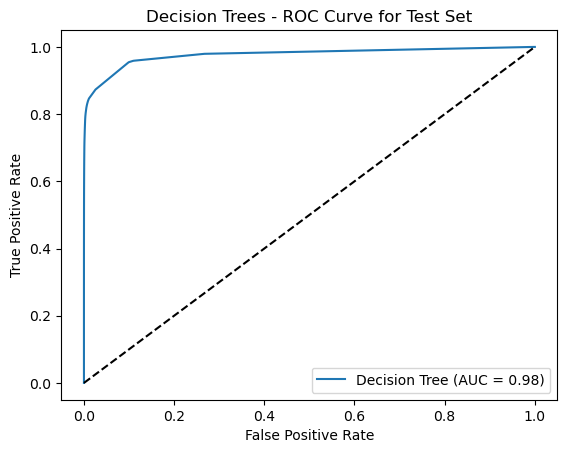

In [170]:
# Assuming you have fraudTest.csv loaded as df_test
# Apply the same preprocessing to fraudTest.csv (X_test and y_test)
    # Generate a timestamp for the report filename
    timestamp = time.strftime("%Y%m%d_%H%M%S")

    y_pred = model.predict(X)
    accuracy = accuracy_score(y, y_pred)
    clf_report = classification_report(y, y_pred)
    print(f"{model_specs}_{dataset_type} Classification Report:\n", clf_report)
    

    
    # Calculate probabilities and AUC
    y_probs = model.predict_proba(X)[:, 1]
    roc_auc = roc_auc_score(y, y_probs)
    fpr, tpr, _ = roc_curve(y, y_probs)
    precision, recall, _ = precision_recall_curve(y, y_probs)
    auc_pr = auc(recall, precision)
    print(f"{model_specs}_{dataset_type} ROC AUC:", roc_auc)
    print(f"{model_specs}_{dataset_type} Precision-Recall AUC:", auc_pr)
    
    # Plot ROC curve
    plt.figure()
    plt.plot(fpr, tpr, color='blue', label=f'{dataset_type} ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - {dataset_type}')
    plt.legend(loc="lower right")
    

    plot_filename = f"{model_specs}_{dataset_type}_RoC_Curve_{timestamp}.png"
    plt.savefig(os.path.join(reports_output_dir, plot_filename))
    plt.close()
    print(f"ROC_Curve saved to {plot_filename}")
    
    # Create and save classification report
    report_filename = f"{model_specs}_{dataset_type}_Report_{timestamp}.txt"
    report_path = os.path.join(reports_output_dir, report_filename)
    full_report = (
        f"Accuracy: {accuracy:.4f}\n\n"
        f"Classification Report:\n{clf_report}\n\n"
        f"ROC AUC: {roc_auc:.4f}\n"
        f"Precision-Recall AUC: {auc_pr:.4f}"
    )
    with open(report_path, "w") as f:
        f.write(full_report)
    print(f"Classification report saved to {report_path}")    
    
    
# One-hot encode categorical variables for fraudTest.csv
X_test_encoded = pd.get_dummies(X, drop_first=True)

# Impute missing values using the same imputer fitted on fraudTrain.csv
X_test_imputed = imputer.transform(X_test_encoded)

# Get predicted probabilities for the positive class (fraud) from the trained Decision Tree model
y_prob_test = decision_tree_model.predict_proba(X_test_imputed)[:, 1]

# Calculate ROC AUC for fraudTest.csv
roc_auc_test = roc_auc_score(y, y_prob_test)
print(f"ROC AUC for Test Set: {roc_auc_test}")

# Plot ROC curve for fraudTest.csv
fpr, tpr, thresholds = roc_curve(y, y_prob_test)
plt.plot(fpr, tpr, label=f"Decision Tree (AUC = {roc_auc_test:.2f})")
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line for random guessing

# Define the title
title = 'Decision Trees - ROC Curve for Test Set'
plt.title(title)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()

# Use the title in the filename
filename = f"{dataset_type}_{title.replace(' ', '_').replace(',', '').lower()}.png"
plt.savefig(os.path.join(reports_output_dir, filename), dpi=300, bbox_inches='tight')


plt.show()


# Here's a way to summarize your Decision Tree model results for your project report:
Summary of Decision Tree Model Performance for Fraud Detection

I developed and evaluated a Decision Tree model to detect fraudulent transactions using both a training dataset (fraudTrain.csv) and a separate test dataset (fraudTest.csv). The following are the key performance metrics obtained from the model evaluation:
Training Set Performance (fraudTrain.csv):

    Precision for fraud (class 1): 0.90
    Recall for fraud (class 1): 0.70
    F1-score for fraud (class 1): 0.79
    Overall accuracy: 1.00
    Macro-average F1-score: 0.89

The model performs well on the training data, with a high precision of 0.90 for detecting fraud, meaning that 90% of the transactions predicted as fraud were correct. However, the recall is slightly lower at 0.70, meaning that 70% of actual fraud cases were detected by the model. This suggests that while the model is good at identifying fraud (high precision), it might miss a portion of the fraudulent transactions (lower recall).
Test Set Performance (fraudTest.csv):

    Precision for fraud (class 1): 0.86
    Recall for fraud (class 1): 0.61
    F1-score for fraud (class 1): 0.71
    Overall accuracy: 1.00
    Macro-average F1-score: 0.86
    ROC-AUC: 0.9765

On the test set, the model continues to perform well, with an overall accuracy of 1.00. The ROC-AUC of 0.9765 indicates that the model is highly effective in distinguishing between fraudulent and non-fraudulent transactions. However, the recall for fraud (0.61) shows that the model still misses some fraud cases, despite its high precision of 0.86.
Interpretation of Results:

    Precision is high in both the training and test sets, indicating that the model correctly identifies most fraud cases it predicts.
    Recall is lower in the test set (0.61), meaning that the model misses some fraud cases in unseen data.
    The ROC-AUC of 0.9765 shows that the model performs very well in separating fraud from non-fraud, making it a good fit for this task.

Conclusion:

The Decision Tree model shows strong performance in identifying fraudulent transactions, especially in terms of precision and overall accuracy. However, the recall could be improved to capture more fraud cases. Additional tuning of the model's hyperparameters or exploring more advanced models like Random Forest or Gradient Boosting could further enhance recall.